In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import ast
from textwrap import wrap

import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn as sk
# from dask_ml.decomposition import PCA
from umap.umap_ import UMAP

import tensorflow as tf
from tensorflow import keras
from tensorboard.plugins import projector

import os
from os.path import join

import multiprocessing as mp
from multiprocessing import Manager

import traceback

import sklearn as sk
from sklearn.pipeline import make_pipeline
import scipy as sp
from tqdm.auto import tqdm

import pickle as pkl

import joblib

2023-11-04 18:25:08.447685: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import sys
sys.path.append("../../")

# Useful for Pylance
from utils import *

import utils
utils.refresh(sys.modules[__name__])

In [22]:
def incrementally_retrieve_distr_array(da_arr_graph):
    da_arr = da_arr_graph.persist(optimize_graph=True)
    assert len(da_arr) >= 1, "Distributed array has to have at least 1 dimension"

    np_arr = np.zeros(da_arr.shape)
    bookmarks = np.cumsum((0,) + da_arr.chunks[0])

    for chk_start, chk_end in zip(bookmarks[:-1], bookmarks[1:]):
        np_arr[chk_start:chk_end] = da_arr[chk_start:chk_end].compute()

    return np_arr
def log_query(embeddings_model_name, compression, query, query_idxs, logfile_name, logfile_dir="logs/"):
    log_filepath = os.path.join(logfile_dir, logfile_name)

    if os.path.exists(log_filepath):
        queries = pd.read_csv(log_filepath, index_col=0, sep=";")
    else:
        queries = pd.DataFrame([], index=pd.RangeIndex(0), columns=['embeddings_model_name', 'compression', 'query', 'query_idxs'])
    
    cur_query_num = queries.shape[0]
    queries = pd.concat([queries, pd.DataFrame({'embeddings_model_name': [embeddings_model_name], 'compression': [compression], 'query': [query], 'query_idxs': [list(query_idxs)]})], ignore_index=True)

    queries.to_csv(log_filepath, sep=";")

    return cur_query_num
def load_query_cache(logfile_name, logfile_dir):
    cache = pd.read_csv(os.path.join(logfile_dir, logfile_name), sep=";")
    cache['query_idxs'] = cache['query_idxs'].apply(ast.literal_eval)

    return cache
def search_query_cache(embeddings_model_name, compression, target_query_idxs, logfile_name, logfile_dir="logs/"):
    if not os.path.exists(os.path.join(logfile_dir, logfile_name)):
        return None

    cache = load_query_cache(logfile_name, logfile_dir)
    
    hits_mask = cache.apply(lambda x: x['embeddings_model_name'] == embeddings_model_name and 
            x['compression'] == compression and 
            len(x['query_idxs']) == target_query_idxs.shape[0] and
            (np.array(x['query_idxs']) == target_query_idxs).all()
        , axis=1)

    if hits_mask.shape[0] == 0:
        return None

    hits_num = hits_mask.sum()
    if hits_num == 0:
        info("Query not found in cache")
        return None
    elif hits_num > 1:
        warn("Multiple queries in cache match the desired one. Recomputing a fresh query")
        return None
    else:
        cached_query = cache[hits_mask]
        info(f"Query found in cache (#{cached_query.iloc[0].name}): '{cached_query.iloc[0]['query']}'")
        return cached_query.iloc[0].name
def resolve_query(embeddings_model_name, compression, query_statement, labels, logfile_name):
    group_idxs = labels.query(query_statement).index.values
    info("Selected", f"{np.round(group_idxs.shape[0] / labels.shape[0] * 100, 2)}%", "of samples", f"({group_idxs.shape[0]})")

    cached_query_num = search_query_cache(embeddings_model_name, compression, group_idxs, logfile_name)

    if cached_query_num is None:
        query_num = log_query(embeddings_model_name, compression, query_statement, group_idxs, logfile_name)
        info(f"Current query registered as #{query_num}")
        return query_num, True, group_idxs
    else:
        return cached_query_num, False, group_idxs
def resolve_compression(orig_dataset_name, embeddings_model_name, compression, logfile_name, logfile_dir='logs/'):
    cache = load_query_cache(logfile_name, logfile_dir)

    in_cache = cache.apply(lambda x: x['embeddings_model_name'] == embeddings_model_name and x['compression'] == compression, axis=1).sum() > 0 
    in_directory = os.path.exists(os.path.join(get_dataset_dir(orig_dataset_name), f"{orig_dataset_name}_{embeddings_model_name}_{compression}.npy"))

    if in_cache and in_directory:
        info("Found known compressed labels")
        return True
    elif in_directory:
        info("Found new compressed labels (not yet in cache)")
        return True
    else:
        return False
def compute_query(orig_dataset_name, embeddings_model_name, compression, query, labels, logfile_name="pca_developability_v2_queries.log"):
    query_num, _, query_idxs = resolve_query(embeddings_model_name, compression, query, labels, logfile_name)

    is_known_compression = resolve_compression(orig_dataset_name, embeddings_model_name, compression, logfile_name)

    if is_known_compression:
        info("Computing query from compressed embeddings")
        compr_embs = np.load(os.path.join(get_dataset_dir(orig_dataset_name), f"{orig_dataset_name}_{embeddings_model_name}_{compression}.npy"))
        query_embs = compr_embs[query_idxs]
    elif 'launch_cluster' in globals():
        info("Computing the query from uncompressed embeddings. Will use a cluster (sit down and enjoy the ride!)")
        cfg_filepath = "compute-infrastructure.cfg"
        cluster, client = launch_cluster(cfg_filepath, 45)
        lazy_embs = load_distributed_dataset(orig_dataset_name, compression='uncompressed', cfg_filepath=cfg_filepath, embeddings_model_name=embeddings_model_name)
        
        info("Initiating compression of embeddings...")
        lazy_compr_embs = reduce_embs(lazy_embs, strategy=compression)

        info("Triggering distributed compression of embeddings...")
        compr_embs = incrementally_retrieve_distr_array(lazy_compr_embs.rechunk())
        info("Result collected")

        client.close()
        cluster.close()

        info("Caching result of computation...")
        np.save(os.path.join(get_dataset_dir(orig_dataset_name), f"{orig_dataset_name}_{embeddings_model_name}_{compression}.npy"), compr_embs)

        query_embs = compr_embs[query_idxs]
    else:
        info("Cluster capabilities not found. Reverting to local computation")
        embs, _, _ = load_dataset(embeddings_model_name, orig_dataset_name, None, ['sequence'], compression="uncompressed", is_split=True, preview=False)

        info("Compressing embeddings...")
        compr_embs = reduce_embs(embs['sequence'], strategy=compression)

        info("Caching compressed embeddings...")
        np.save(os.path.join(get_dataset_dir(orig_dataset_name), f"{orig_dataset_name}_{embeddings_model_name}_{compression}.npy"), compr_embs)

        query_embs = compr_embs[query_idxs]

    info("Caching queried embeddings...")
    np.save(os.path.join(get_dataset_dir(orig_dataset_name), f"{orig_dataset_name}_{embeddings_model_name}_query-{query_num}_{compression}.npy"), query_embs)

    query_labels = labels.loc[query_idxs]

    return query_embs, query_labels, query_num
class LazyEmbeddings:
    def __init__(self, orig_dataset_name, embeddings_model_name, compression_method, labels):
        self.orig_dataset_name = orig_dataset_name
        self.embeddings_model_name = embeddings_model_name
        self.compression = compression_method
        self.orig_labels = labels

        self.dataset_labels = None
        self.dataset_embs = None
        
        self.query = None
        self.query_num = None
        self.query_embs = None
        self.query_labels = None

    def _check_computation(self):
        if self.query is None or self.query_embs is None:
            raise ValueError("Embeddings must be queried in order for them to be actually computed")

    def compute(self, query):
        self.query = query
        self.dataset_embs, self.dataset_labels, self.query_num = compute_query(self.orig_dataset_name, self.embeddings_model_name, self.compression, query, self.orig_labels, logfile_name=f"pca_{self.orig_dataset_name}_{self.embeddings_model_name}_{self.compression}_queries.log")

        return self

    def _split(embs, labels, split):
        if split is None:
            return embs, labels
        else:
             return embs[split], labels.reset_index().loc[split]

    def split(self, split=None, copy=False):
        if copy:
            _embs, _labels = LazyEmbeddings._split(self.dataset_embs, self.dataset_labels, split)

            # TODO: Refactor
            other = LazyEmbeddings(self.orig_dataset_name, self.embeddings_model_name, self.compression, self.orig_labels)
        
            other.query = self.query
            other.query_num = self.query_num

            other.dataset_labels = _labels
            other.dataset_embs = _embs
            
            other.split(copy=False)

            return other
        else:
            self.query_embs, self.query_labels = LazyEmbeddings._split(self.dataset_embs, self.dataset_labels, split)

        return self

    def get_query(self):
        self._check_computation()
        return self.query

    def get_query_num(self):
        self._check_computation()
        return self.query_num

    def get_embs(self):
        self._check_computation()
        return self.query_embs

    def get_labels(self):
        self._check_computation()
        return self.query_labels
def compute_dimensionality_reduction(orig_dataset_name, embeddings_model_name, compression, query_num, embs, embs_dim_reduction, expl_var_logfile_name="pca_developability_explained_variance_ration.csv"):
    if isinstance(embs_dim_reduction, str):
        embs_dim_reduction_name = embs_dim_reduction
        if embs_dim_reduction_name == 'pca':
            embs_dim_reduction = sk.decomposition.PCA(n_components=3)
        elif embs_dim_reduction_name == 'umap':
            embs_dim_reduction = UMAP(n_components=3)
        else:
            raise ValueError("Unkown dim. reduction strategy: ", embs_dim_reduction_name)

        info("Fitting dimensionality reduction...")
        reduction = embs_dim_reduction.fit(embs)

    elif callable(getattr(embs_dim_reduction, "transform", None)):
        embs_dim_reduction_name = embs_dim_reduction.__class__.__name__.lower()
        info(f"Applying precomputed dimensionality reduction ({embs_dim_reduction_name})")
        reduction = embs_dim_reduction

    else:
        raise ValueError("Unkown dim. reduction strategy: ", embs_dim_reduction_name, "Can only specify name or precomputed method")
    
    info("Applying dimensionality reduction...")
    embs_reduced = reduction.transform(embs)

    if  hasattr(reduction, "explained_variance_ratio_"):
        info("Explained variance:", reduction.explained_variance_ratio_)
        log_info(expl_var_logfile_name, query_num, str(reduction.explained_variance_ratio_))

    plt.scatter(embs_reduced[:,0], embs_reduced[:,1], s=.05, alpha=.4);
    plt.show()

    info("Saving reduced embeddings to file...")

    np.save(os.path.join(get_dataset_dir(orig_dataset_name), f"{embs_dim_reduction_name}/{orig_dataset_name}_query-{query_num}_{embeddings_model_name}_{compression}.npy"), embs_reduced)

    return reduction, embs_reduced
sampling_factor = 1
def plot_metric(orig_dataset_name, embeddings_model_name, compression, embs_dim_reduction, embs_reduced, labels, curr_metric, first_axis, second_axis, grey_zone, c_plt, is_categorical):
    metric_labels = labels[curr_metric]

    if is_categorical or not is_numeric_dtype(metric_labels):
        if metric_labels.dtype.name != "object":
            metric_labels = metric_labels.astype('Int64')
        metric_labels = metric_labels.astype('category', copy=True)
        # print(metric_labels.unique())

    metric_labels = metric_labels[::sampling_factor]
        
    return plot_pca(embs_reduced[::sampling_factor], metric_labels, first_axis, second_axis, invisible_zone=0., grey_zone=grey_zone, min_alpha=.05, max_alpha=.95, labels_preview=False, s=1., colormap='RdYlGn', ax=c_plt)

    # except Exception as e:
    #     # Killing exceptions to avoid interruption of long-running proces
    #     # TODO: Add logging
    #     error(curr_metric, ":", e)
    #     traceback.format_exc()
def generate_graphs(orig_dataset_name, embeddings_model_name, compression, embs_dim_reduction, embs_reduced, labels, query_num, worker_metrics, is_categorical, queue=None, first_axis=0, second_axis=1, grey_zone = .3, background=None):
    # Force matplotlib backend
    import matplotlib as mpl
    import matplotlib.pyplot as c_plt
    mpl.use('Agg')    

    if background is not None:
        if embeddings_model_name != background.compressed_embs.embeddings_model_name or compression != background.compressed_embs.compression:
            raise ValueError("Background cloud should sahre 'embeddings_model_name' and 'compression' with foreground")

    for curr_metric in tqdm(worker_metrics):
        c_plt.figure(figsize=(6.4, 4.8))

        if background is not None and curr_metric not in background.compressed_embs.get_labels().columns.values:
            background_metric = background.compressed_embs.get_labels().columns.values[-1]
            warn(f"Cannot draw background for metric {curr_metric} (not found among columns). Using metric {background_metric} instead")
        else:
            background_metric = curr_metric

        if background is not None:
            # Draw background
            background._plot_metric((c_plt, c_plt), background_metric, grey_zone=1., is_categorical=is_categorical, first_axis=first_axis, second_axis=second_axis)

        c_cbar = plot_metric(orig_dataset_name, embeddings_model_name, compression, embs_dim_reduction, embs_reduced, labels, curr_metric, first_axis, second_axis, grey_zone, (c_plt, c_plt), is_categorical)

        if background is not None:
            complete_dataset_name = f"(B)_{background.compressed_embs.orig_dataset_name}_(F)_{orig_dataset_name}"
        else:
            complete_dataset_name = orig_dataset_name

        c_plt.gca().set_title(
            as_title(
                embs_dim_reduction,
                embeddings_model_name,
                complete_dataset_name,
                f"query-{query_num}",
                compression,
                curr_metric,
                first_axis, second_axis));
        c_plt.savefig(relative_path(f"figures/{embs_dim_reduction.__class__.__name__.lower()}/{orig_dataset_name}/", 
            as_title(
                embs_dim_reduction, 
                embeddings_model_name, 
                complete_dataset_name,
                f"query-{query_num}",
                compression, 
                curr_metric, 
                first_axis, second_axis, line_sep="-") + ".png"),
                bbox_inches='tight',
                dpi=400)
        c_plt.savefig(relative_path(f"figures/{embs_dim_reduction.__class__.__name__.lower()}/{orig_dataset_name}/", 
            as_title(
                embs_dim_reduction, 
                embeddings_model_name, 
                complete_dataset_name,
                f"query-{query_num}",
                compression, 
                curr_metric, 
                first_axis, second_axis, line_sep="-") + ".pdf"),
                format="pdf",
                bbox_inches='tight',
                dpi=400)
        c_plt.show();

        # TODO: Improve this
        if c_cbar is not None:
            c_cbar.remove()
        
        if queue is not None:
            queue.put(1)
        
def display_metric(orig_dataset_name, embeddings_model_name, compression, query_num, embs_dim_reduction, embs_reduced, labels, metric, is_categorical=False, grey_zone = .3, background=None):
    worker_metrics = np.array([metric])
    generate_graphs(orig_dataset_name, embeddings_model_name, compression, embs_dim_reduction, embs_reduced, labels, query_num, worker_metrics, is_categorical, grey_zone=grey_zone, background=background)

    info("Graph successfully generated")
def display_all_metrics(orig_dataset_name, embeddings_model_name, compression, query_num, embs_dim_reduction, embs_reduced, labels, is_categorical=False, grey_zone = .3, background=None, first_axis=0, second_axis=1, parallel_exec=True):
    info("Automatically inferring the metrics used to produce graphs")
    metric_names = labels.columns.values[pd.Series(labels.columns.values).str.extract("(AbOrig|AbChain|AbStruc).*").notna().values.ravel()]

    if parallel_exec:
        workers_num = mp.cpu_count()
        worker_metrics = np.array_split(metric_names, workers_num)

        manager = Manager()
        queue = manager.Queue(maxsize=2*workers_num)

        with mp.Pool() as p:
            info(f"Launching parallel graph generation ({workers_num} processes)...")
            _ = p.starmap_async(generate_graphs, [(orig_dataset_name, embeddings_model_name, compression, embs_dim_reduction, embs_reduced, labels, query_num, metric, is_categorical, queue, first_axis, second_axis, grey_zone, background) for metric in worker_metrics])

            for _ in tqdm(range(metric_names.shape[0])):
                queue.get()
    else:
        info("Parallel generation of graphs disabled. Proceeding sequentially...")
        generate_graphs(orig_dataset_name, embeddings_model_name, compression, embs_dim_reduction, embs_reduced, labels, query_num, metric_names, is_categorical, None, first_axis, second_axis, grey_zone, background)

    info("Graphs successfully generated")
class ProjectedEmbeddings:
    def __init__(self, compressed_embs: LazyEmbeddings):
        self.compressed_embs = compressed_embs

        self.reduction = None
        self.reduced_embs = None

    def project(self, dim_reduction):
        self.reduction, self.reduced_embs = compute_dimensionality_reduction(
            self.compressed_embs.orig_dataset_name,
            self.compressed_embs.embeddings_model_name,
            self.compressed_embs.compression, 
            self.compressed_embs.query_num,
            self.compressed_embs.get_embs(), 
            dim_reduction,
            expl_var_logfile_name=f"pca_{self.compressed_embs.orig_dataset_name}_{self.compressed_embs.embeddings_model_name}_explained_variance_ration.csv"
        )

        return self

    def _check_projection(self):
        if self.reduction is None:
            raise ValueError("Must project the embeddings first, before plotting them on a graph")

    def get_reduction(self):
        self._check_projection()
        return self.reduction

    def get_reduced_embs(self):
        self._check_projection()
        return self.reduced_embs

    def get_reduction_name(self):
        self._check_projection()

        return self.reduction.__class__.__name__.lower()

    def _plot_metric(self, c_plt, metric_name, grey_zone, is_categorical, first_axis=0, second_axis=1):
        self._check_projection()
        return plot_metric(
            self.compressed_embs.orig_dataset_name,
            self.compressed_embs.embeddings_model_name,
            self.compressed_embs.compression,
            self.reduction,
            self.reduced_embs,
            self.compressed_embs.get_labels(),
            metric_name,
            first_axis,
            second_axis,
            grey_zone,
            c_plt,
            is_categorical
        )

    def display(self, metric, is_categorical=False, grey_zone=.3, background=None):
        self._check_projection()
        display_metric(
            self.compressed_embs.orig_dataset_name,
            self.compressed_embs.embeddings_model_name,
            self.compressed_embs.compression,
            self.compressed_embs.query_num,
            self.reduction,
            self.reduced_embs,
            self.compressed_embs.get_labels(),
            metric,
            is_categorical,
            grey_zone,
            background
        )

        return self

    def list_metrics(self):
        return self.compressed_embs.get_labels().columns.values[pd.Series(self.compressed_embs.get_labels().columns.values).str.extract("(AbOrig|AbChain|AbStruc).*").notna().values.ravel()]

    def compare(self, other, metric_name, is_categorical=False, grey_zone=.3):
        tot_size_x, tot_size_y = (2*6.4 + 2*.3, 4.8)
        def _rel(x, y):
            return x/tot_size_x, y/tot_size_y

        fig = plt.figure(figsize=(tot_size_x, tot_size_y))
        
        ax_other = fig.add_axes((0, 0) + _rel(6.4, 4.8))
        other_cbar = other._plot_metric((fig, ax_other), metric_name, grey_zone=grey_zone, is_categorical=is_categorical)

        if other_cbar is not None:
            ax_cbar_other = fig.add_axes(_rel(6.4-1.1, 0) + _rel(.2, 4.8))
            fig.colorbar(other_cbar.mappable, cax=ax_cbar_other, spacing="proportional")
            other_cbar.remove()
        else:
            ax_other.get_legend()
        
        ax_this = fig.add_axes(_rel(6.4+.2, 0) + _rel(6.4, 4.8))
        other._plot_metric((fig, ax_this), metric_name, grey_zone=1., is_categorical=is_categorical)
        self_cbar = self._plot_metric((fig, ax_this), metric_name, grey_zone=grey_zone, is_categorical=is_categorical)

        if self_cbar is not None:
            ax_cbar_this = fig.add_axes(_rel(2*6.4+.2-1.1, 0) + _rel(.2, 4.8))
            fig.colorbar(self_cbar.mappable, cax=ax_cbar_this, spacing="proportional")
            self_cbar.remove()

        ax_other.set_title(
            as_title(
                other.reduction,
                other.compressed_embs.embeddings_model_name,
                other.compressed_embs.orig_dataset_name,
                f"query-{other.compressed_embs.query_num}",
                other.compressed_embs.compression,
                metric_name,
                0, 1));

        complete_dataset_name = f"(B)_{other.compressed_embs.orig_dataset_name}_(F)_{self.compressed_embs.orig_dataset_name}"
        ax_this.set_title(
            as_title(
                self.reduction,
                self.compressed_embs.embeddings_model_name,
                complete_dataset_name,
                f"query-{self.compressed_embs.query_num}",
                self.compressed_embs.compression,
                metric_name,
                0, 1));
        fig.savefig(relative_path(f"figures/{self.reduction.__class__.__name__.lower()}/comparison/", 
            as_title(
                self.reduction, 
                self.compressed_embs.embeddings_model_name, 
                f"{other.compressed_embs.orig_dataset_name}_vs_{self.compressed_embs.orig_dataset_name}",
                f"queries-{other.compressed_embs.query_num},{self.compressed_embs.query_num}",
                self.compressed_embs.compression, 
                metric_name, 
                0, 1, line_sep="-") + ".png"),
                bbox_inches='tight',
                dpi=400)

        fig.show();

        return self

    def display_all(self, grey_zone=.3, background=None, parallel_exec=True):
        self._check_projection()
        display_all_metrics(
            self.compressed_embs.orig_dataset_name,
            self.compressed_embs.embeddings_model_name,
            self.compressed_embs.compression,
            self.compressed_embs.query_num,
            self.reduction,
            self.reduced_embs,
            self.compressed_embs.get_labels(),
            False,
            grey_zone,
            background,
            parallel_exec=parallel_exec
        )

        return self

    def inspect(self, columns=None, save_dir='views'):
        self._check_projection()

        chk_base_name = f"{self.get_reduction_name()}_{self.compressed_embs.orig_dataset_name}_query-{self.compressed_embs.query_num}_{self.compressed_embs.embeddings_model_name}_{self.compressed_embs.compression}"
        proj_embs_var = tf.Variable(self.reduced_embs, name=chk_base_name)
        proj_embs_chk = tf.train.Checkpoint(embedding=proj_embs_var)
        
        chk_path = save_dir
        if not os.path.exists(chk_path):
            os.mkdir(chk_path)

        chk_name = chk_base_name + ".ckpt"
        proj_embs_chk.save(os.path.join(chk_path, chk_name))

        if columns is None:
            points_labels = self.compressed_embs.get_labels()
        else:
            points_labels = self.compressed_embs.get_labels()[columns]

        graph_labels_filename = f"{self.compressed_embs.orig_dataset_name}_graph_labels.tsv"
        points_labels.to_csv(os.path.join(save_dir, graph_labels_filename), "\t")

        config = projector.ProjectorConfig()
        embs_config = config.embeddings.add()
        embs_config.tensor_name = "embeddings"
        embs_config.metadata_path = graph_labels_filename

        projector.visualize_embeddings(save_dir, config)
        %load_ext tensorboard
        abs_save_dir = os.path.join(os.path.abspath("."), save_dir)
        %tensorboard --logdir $abs_save_dir
def inspect(self, columns=None, save_dir='views'):
    self._check_projection()

    rand_idxs = np.random.permutation(self.reduced_embs.shape[0])[:50000]

    chk_base_name = f"{self.get_reduction_name()}_{self.compressed_embs.orig_dataset_name}_query-{self.compressed_embs.query_num}_{self.compressed_embs.embeddings_model_name}_{self.compressed_embs.compression}"
    proj_embs_var = tf.Variable(self.reduced_embs[rand_idxs].astype('float32'), name=chk_base_name)
    proj_embs_chk = tf.train.Checkpoint(embedding=proj_embs_var)
    
    chk_path = save_dir
    if not os.path.exists(chk_path):
        os.mkdir(chk_path)

    chk_name = chk_base_name + ".ckpt"
    proj_embs_chk.save(os.path.join(chk_path, chk_name))

    print(os.path.join(chk_path, chk_name))

    if columns is None:
        all_columns = self.compressed_embs.get_labels().columns
        points_labels = self.compressed_embs.get_labels()[all_columns[all_columns.str.contains(r"(AbOrig|AbChain|AbStruc)")].values]
    else:
        points_labels = self.compressed_embs.get_labels()[columns]

    points_labels = points_labels.iloc[rand_idxs]

    graph_labels_filename = f"{self.compressed_embs.orig_dataset_name}_graph_labels.tsv"
    points_labels.reset_index(drop=True).to_csv(os.path.join(save_dir, graph_labels_filename), "\t")

    assert points_labels.shape[0] == proj_embs_var.shape[0]

    print(os.path.join(save_dir, graph_labels_filename))

    config = projector.ProjectorConfig()
    embs_config = config.embeddings.add()
    embs_config.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
    embs_config.metadata_path = graph_labels_filename

    abs_save_dir = os.path.join(os.path.abspath("."), save_dir)
    print(abs_save_dir)
    projector.visualize_embeddings(abs_save_dir, config)
    %reload_ext tensorboard
    %tensorboard --logdir $abs_save_dir --reload_multifile true
def norm_features(feats, means=None, stds=None):
    if means is None:
        means = feats.mean(axis=0)
    
    if stds is None:
        stds = feats.std(axis=0)

    return (feats - means) / stds, means, stds

In [4]:
## Select chain type and species
chain_type = "light"
orig_species = "human"

In [5]:
mwds_names = pd.read_csv("reproducibility/mwds_names.csv").columns.to_numpy()
complete_mwds_names = np.array(["AbChain_14_charge", "AbChain_acidic_content", "AbChain_aliphatic_content", "AbChain_aromatic_content", "AbChain_hmom", "AbChain_hydrophobicity", "AbChain_instaindex", "AbChain_molextcoef", "AbChain_nonpolar_content", "AbChain_small_content", "AbChain_solubility", "AbStruc_alpha_helices", "AbStruc_aromatic_interactions", "AbStruc_atom_plane_sum", "AbStruc_beta_bends", "AbStruc_beta_bridges", "AbStruc_beta_strands", "AbStruc_beta_turns", "AbStruc_carbonyl_interactions", "AbStruc_covbonds", "AbStruc_cys_bridges", "AbStruc_donor_pi_interactions", "AbStruc_folded_pI", "AbStruc_folding_energy", "AbStruc_free_cys", "AbStruc_hbonds", "AbStruc_ibonds", "AbStruc_loops", "AbStruc_ncharge_hetrgen", "AbStruc_pbonds", "AbStruc_pcharge_hetrgen", "AbStruc_phi_angle", "AbStruc_pi_helices", "AbStruc_plane_group_interactions", "AbStruc_psi_angle", "AbStruc_sasa", "AbStruc_steric_clashes", "AbStruc_vdw_clashes", "AbStruc_vdw_interactions", "AbStruc_weak_hbonds"])

In [6]:
add_idx = np.where(complete_mwds_names == np.setdiff1d(complete_mwds_names, mwds_names)[0])[0]
add_mask = np.ones(complete_mwds_names.shape[0]).astype(bool)
add_mask[add_idx] = False

# Compare Abs fingerprints

## Fit PLM projection

In [7]:
# native_embs = LazyEmbeddings("developability", "esm-1v-1", "bos", pd.read_csv(os.path.join(get_dataset_dir("developability"), "developability.csv"))).compute(f"chain_type == '{chain_type}' and AbOrig_species == '{orig_species}'").split()

In [8]:
# native_proj = ProjectedEmbeddings(native_embs).project('pca')
# joblib.dump(native_proj.reduction, f"reproducibility/v3_{chain_type}-{orig_species}-full_native_pca.joblib")

## Create PLM and MWDS projections

In [9]:
plm_pca = joblib.load(f"reproducibility/v3_{chain_type}-{orig_species}-full_native_pca.joblib")

/home/ec2-user/ml-binding/lib64/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator PCA from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [10]:
native_labels = pd.read_csv(os.path.join(get_dataset_dir("developability"), "developability.csv"))

In [11]:
all_native_mwds_embs = np.load(os.path.join(get_dataset_dir("developability"), f"developability_mwds_seq.npy"))
selected_idxs = native_labels.query(f"AbOrig_species == '{orig_species}' and chain_type == '{chain_type}'").index

native_mwds_embs = all_native_mwds_embs[selected_idxs][:,add_mask]
native_mwds_embs.shape

(385633, 39)

In [12]:
# # Fit MWDS pca
# mwds_pca = sk.decomposition.PCA(2)
# mwds_pca.fit(native_mwds_embs)

# joblib.dump(mwds_pca, f"reproducibility/v3_{chain_type}-{orig_species}-native_mwds_pca.joblib")

In [13]:
mwds_pca = joblib.load(f"reproducibility/v3_{chain_type}-{orig_species}-native_mwds_pca.joblib")

In [14]:
files_prefix = f"reproducibility/v3_{chain_type}-{orig_species}"
def as_metadata(dataset_name):
    return f"{files_prefix}-{dataset_name}_metadata.csv"

def as_plm_proj(dataset_name):
    return f"{files_prefix}-{dataset_name}_esm-1v-1_proj.npy"

def as_mwds_proj(dataset_name):
    return f"{files_prefix}-{dataset_name}_mwds_proj.npy"

## Preprocessing
#### Prepare **Kymouse** dataset (run ONLY for human heavy chains)

In [ ]:
assert chain_type == "heavy" and orig_species == "human"

# Save metadata
kymouse_dataset_name = "developability-humanised"
pd.read_csv(os.path.join(get_dataset_dir(kymouse_dataset_name), f"{kymouse_dataset_name}.csv")).to_csv(as_metadata(kymouse_dataset_name))
np.save(as_mwds_proj(kymouse_dataset_name), mwds_pca.transform(np.load(os.path.join(get_dataset_dir(kymouse_dataset_name), f"{kymouse_dataset_name}_mwds_seq.npy"))[:,add_mask]))

# # Concatenate orig embs into single file
# concat_embs = np.concatenate([np.load(os.path.join(get_dataset_dir("developability_humanised"), f"developability-humanised_esm-1v-1_bos_p{i}.npz"))['arr_0'] for i in range(26)], axis=0)
# np.save(os.path.join(get_dataset_dir("developability-humanised"), "developability-humanised_esm-1v-1_bos.npy"), concat_embs)

humanised_plm_embs = np.load(os.path.join(get_dataset_dir(kymouse_dataset_name), f"{kymouse_dataset_name}_esm-1v-1_bos.npy"))
humanised_plm_proj = plm_pca.transform(humanised_plm_embs)
np.save(as_plm_proj(kymouse_dataset_name), humanised_plm_proj)

#### Prepare **PAD** embeddings (dataset **NOT** included in public repo: do not run)

In [ ]:
####
# Redacted code
####

### Prepare **native** abs

In [17]:
native_dataset_name = "developability"
native_labels = pd.read_csv(os.path.join(get_dataset_dir(native_dataset_name), f"{native_dataset_name}.csv"))
human_native_labels = native_labels.query(f"AbOrig_species == '{orig_species}' and chain_type == '{chain_type}'")

In [18]:
# Specify here subsampling, to speed-up the computation
native_idxs = human_native_labels.index.to_numpy()
np.random.shuffle(native_idxs)
native_idxs = np.sort(native_idxs)

In [23]:
native_embs = LazyEmbeddings("developability", "esm-1v-1", "bos", native_labels).compute("chain_type != ''").split(native_idxs)

[INFO] Selected 100.0% of samples (2036789)
[INFO] Query found in cache (#0): 'chain_type != '''
[INFO] Found known compressed labels
[INFO] Computing query from compressed embeddings
[INFO] Caching queried embeddings...


In [24]:
native_embs.get_labels().to_csv(as_metadata("developability"))

In [25]:
np.save(as_plm_proj("developability"), plm_pca.transform(native_embs.get_embs()))

In [26]:
native_mwds_embs = LazyEmbeddings("developability", "mwds", "seq", native_labels).compute("chain_type != ''").split(native_idxs)

[INFO] Selected 100.0% of samples (2036789)
[INFO] Current query registered as #0
[INFO] Found known compressed labels
[INFO] Computing query from compressed embeddings
[INFO] Caching queried embeddings...


In [27]:
np.save(as_mwds_proj("developability"), mwds_pca.transform(native_mwds_embs.get_embs()[:,add_mask]))

### Prepare **thera** abs

In [28]:
thera_dataset_name = "developability-thera"
full_thera_labels = pd.read_csv(os.path.join(get_dataset_dir(thera_dataset_name), f"{thera_dataset_name}.csv"))
subsampling_thera_idxs = full_thera_labels.query(f"chain_type == '{chain_type}' and AbOrig_species == '{orig_species}'").index.to_numpy()

In [29]:
full_thera_labels.loc[subsampling_thera_idxs].to_csv(as_metadata("developability-thera"))

In [30]:
thera_mwds = np.load(os.path.join(get_dataset_dir("developability-thera"), "developability-thera_mwds_seq.npy"))[subsampling_thera_idxs]

In [31]:
thera_embs = np.load(os.path.join(get_dataset_dir("developability-thera"), "developability-thera_esm-1v-1_bos.npy"))[subsampling_thera_idxs]

np.save(as_mwds_proj("developability-thera"), mwds_pca.transform(thera_mwds))
np.save(as_plm_proj("developability-thera"), plm_pca.transform(thera_embs))

## Analysis

In [32]:
# pad_mwds_proj = np.load(as_mwds_proj("developability-patented"))
thera_mwds_proj = np.load(as_mwds_proj("developability-thera"))
native_mwds_proj = np.load(as_mwds_proj("developability"))

if chain_type == "heavy":
    humanised_mwds_proj = np.load(as_mwds_proj("developability-humanised"))

In [33]:
# Load PLM projected embs
# pad_plm_proj = np.load(as_plm_proj("developability-patented"))
thera_plm_proj = np.load(as_plm_proj("developability-thera"))
native_plm_proj = np.load(as_plm_proj("developability"))

if chain_type == "heavy":
    humanised_plm_proj = np.load(as_plm_proj("developability-humanised"))

In [34]:
def draw_native_ab_support(native):
    if isinstance(native, np.ndarray):
        feats = native
    else:
        feats = native.get_reduced_embs()
    plt.scatter(*feats.T[:2], alpha=1., s=.01, color="black", label="Native")
    plt.axis("equal")

In [35]:
def draw_foreground_ab(ab, color="#c9a847", **kwargs):
    if isinstance(ab, np.ndarray):
        feats = ab
    else:
        feats = ab.get_reduced_embs()
    kwargs['s'] = kwargs.get('s', .5)
    plt.scatter(*feats.T[:2], color=color, **kwargs)

### PLM embedding

In [36]:
def format_graph(emb_type):
    if emb_type == "plm":
        plt.title(f"{orig_species.capitalize()}+{chain_type.capitalize()} | ESM-1v-1");
        plt.xlabel(f"PC1 ({plm_pca.explained_variance_ratio_[0]:.2f})");
        plt.ylabel(f"PC2 ({plm_pca.explained_variance_ratio_[1]:.2f})");
    elif emb_type == "mwds":
        plt.title(f"{orig_species.capitalize()}+{chain_type.capitalize()} | MWDS");
        plt.xlabel(f"PC1 ({mwds_pca.explained_variance_ratio_[0]:.2f})");
        plt.ylabel(f"PC2 ({mwds_pca.explained_variance_ratio_[1]:.2f})");
    plt.legend();
    plt.xticks([]);
    plt.yticks([]);

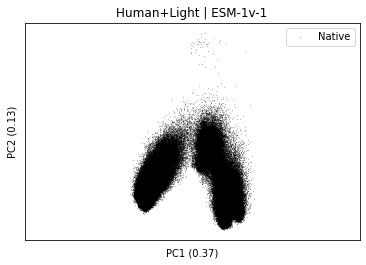

In [37]:
draw_native_ab_support(native_plm_proj)
format_graph(emb_type="plm")
plt.savefig(f"reproducibility/v3_plm_{chain_type}-{orig_species}-native.png", dpi=600)

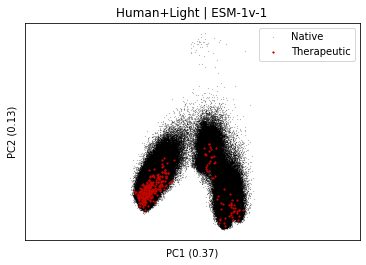

In [ ]:
draw_native_ab_support(native_plm_proj)
draw_foreground_ab(thera_plm_proj, s=1.5, color="#c10600", label="Therapeutic")
format_graph(emb_type="plm")
plt.savefig(f"reproducibility/v3_plm_{chain_type}-{orig_species}-therapeutic.png", dpi=600)

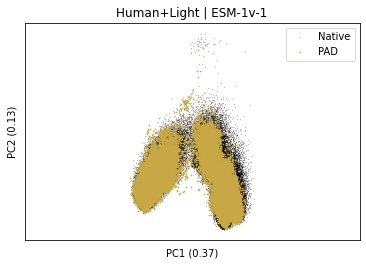

In [ ]:
# draw_native_ab_support(native_plm_proj)
# draw_foreground_ab(pad_plm_proj, color="#c9a847", label="PAD")
# format_graph(emb_type="plm")
# plt.savefig(f"reproducibility/v3_plm_{chain_type}-{orig_species}-pad.png", dpi=600)

In [ ]:
if chain_type == "heavy":
    draw_native_ab_support(native_plm_proj)
    draw_foreground_ab(humanised_plm_proj, color="#00545d", label="Humanised")
    format_graph(emb_type="plm")
    plt.savefig(f"reproducibility/v3_plm_{chain_type}-{orig_species}-humanised.png", dpi=600)

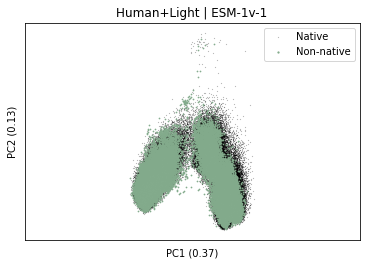

In [ ]:
draw_native_ab_support(native_plm_proj)
draw_foreground_ab(thera_plm_proj, s=1.5, color="#83ab8c", label="Non-native")
# draw_foreground_ab(pad_plm_proj, color="#83ab8c")
if chain_type == "heavy":
    draw_foreground_ab(humanised_plm_proj, color="#83ab8c")
format_graph(emb_type="plm")
plt.savefig(f"reproducibility/v3_plm_{chain_type}-{orig_species}-all.png", dpi=600)

### Developability profile embedding

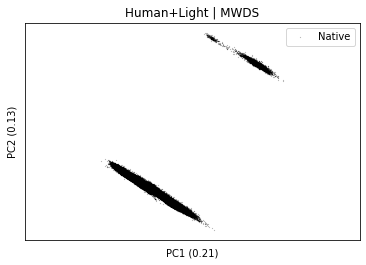

In [ ]:
draw_native_ab_support(native_mwds_proj)
format_graph(emb_type="mwds")
plt.savefig(f"reproducibility/v3_mwds_{chain_type}-{orig_species}-native.png", dpi=600)

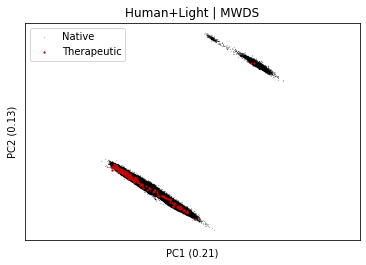

In [ ]:
draw_native_ab_support(native_mwds_proj)
draw_foreground_ab(thera_mwds_proj, s=1.5, color="#c10600", label="Therapeutic")
format_graph(emb_type="mwds")
plt.savefig(f"reproducibility/v3_mwds_{chain_type}-{orig_species}-therapeutic.png", dpi=600)

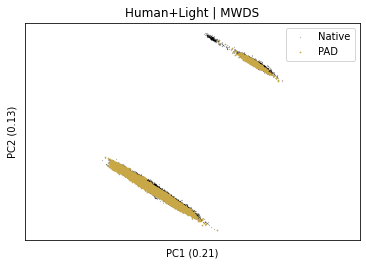

In [ ]:
# draw_native_ab_support(native_mwds_proj)
# draw_foreground_ab(pad_mwds_proj, color="#c9a847", label="PAD")
# format_graph(emb_type="mwds")
# plt.savefig(f"reproducibility/v3_mwds_{chain_type}-{orig_species}-pad.png", dpi=600)

In [ ]:
if chain_type == "heavy":
    draw_native_ab_support(native_mwds_proj)
    draw_foreground_ab(humanised_mwds_proj, color="#00545d", label="Humanised")
    format_graph(emb_type="mwds")
    plt.savefig(f"reproducibility/v3_mwds_{chain_type}-{orig_species}-humanised.png", dpi=600)